<a href="https://colab.research.google.com/github/IP1102/Face-Mask-Detection/blob/master/face_mask_train_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

Using TensorFlow backend.


In [ ]:
img = []
label = []
for file in os.listdir('/content/drive/My Drive/Data/Face Mask Detector/with_mask'):
  img.append(img_to_array(tf.keras.preprocessing.image.load_img('/content/drive/My Drive/Data/Face Mask Detector/with_mask/'+file,target_size=(224,224))))
  label.append('With Mask')

for file in os.listdir('/content/drive/My Drive/Data/Face Mask Detector/without_mask'):
  img.append(img_to_array(tf.keras.preprocessing.image.load_img('/content/drive/My Drive/Data/Face Mask Detector/without_mask/'+file,target_size=(224,224))))
  label.append('Without Mask')

In [ ]:
print(len(img))
print(len(label))

img_ar = np.array(img)
label_ar = np.array(label)

print(img_ar.shape)
print(label_ar.shape)


1376
1376
(1376, 224, 224, 3)
(1376,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_ar_enc = le.fit_transform(label_ar)
label_ar_enc

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
from keras.utils import to_categorical
label_ar_enc = to_categorical(label_ar_enc)
label_ar_enc

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(img_ar,label_ar_enc, test_size = 0.3)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255



In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
 width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
 horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x_train, y_train,batch_size=30)
test_generator = test_datagen.flow(x_test, y_test, batch_size=30)

# Training on Pre Trained Models

VGG16

In [ ]:
from keras.applications import VGG16
from keras.models import Model
import keras
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.optimizers import SGD,RMSprop

vgg = VGG16(include_top = False,
                  weights = 'imagenet',
                  input_shape = (224,224,3))

# output = vgg.layers[-1].output
# output = keras.layers.Flatten()(output)

# vgg = Model(vgg.input, output=output)
# for layer in vgg.layers:
#     layer.trainable = False
# vgg.summary()

for layer in vgg.layers:
  layer.trainable = False

out = vgg.layers[-1].output
flat1 = Flatten()(out)
den1 = Dense(128,activation = 'relu')(flat1)
reg1 = Dropout(0.3)(den1)
out = Dense(1,activation='sigmoid')(reg1)

model = Model(vgg.inputs,out)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])




In [ ]:
history = model.fit_generator(train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 50,
                              verbose = 1,
                              validation_data = test_generator,
                              validation_steps=len(test_generator))

Epoch 1/50
33/33 [==============================] - 17s 504ms/step - loss: 0.7633 - accuracy: 0.4849 - val_loss: 0.6989 - val_accuracy: 0.4770
Epoch 2/50
33/33 [==============================] - 10s 312ms/step - loss: 0.6989 - accuracy: 0.5036 - val_loss: 0.6843 - val_accuracy: 0.4770
Epoch 3/50
33/33 [==============================] - 12s 349ms/step - loss: 0.6946 - accuracy: 0.4974 - val_loss: 0.6890 - val_accuracy: 0.4770
Epoch 4/50
33/33 [==============================] - 12s 349ms/step - loss: 0.6937 - accuracy: 0.4953 - val_loss: 0.6965 - val_accuracy: 0.4770
Epoch 5/50
33/33 [==============================] - 12s 356ms/step - loss: 0.6941 - accuracy: 0.4579 - val_loss: 0.6931 - val_accuracy: 0.5230
Epoch 6/50
33/33 [==============================] - 12s 354ms/step - loss: 0.6932 - accuracy: 0.5078 - val_loss: 0.6932 - val_accuracy: 0.4770
Epoch 7/50
33/33 [==============================] - 12s 349ms/step - loss: 0.6931 - accuracy: 0.5119 - val_loss: 0.6931 - val_accuracy: 0.4770

In [ ]:
model.save('/content/drive/My Drive/Data/Face Mask Detector/face_mask_vgg16.h5')

Resnet50

In [ ]:
from keras.applications import ResNet50
from keras.models import Model
import keras
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.optimizers import SGD,RMSprop

resnet = ResNet50(include_top = False,
                  weights = 'imagenet',
                  input_shape = (224,224,3))

# output = vgg.layers[-1].output
# output = keras.layers.Flatten()(output)

# vgg = Model(vgg.input, output=output)
# for layer in vgg.layers:
#     layer.trainable = False
# vgg.summary()

for layer in resnet.layers:
  layer.trainable = False

out = resnet.layers[-1].output
flat1 = Flatten()(out)
den1 = Dense(128,activation = 'relu')(flat1)
reg1 = Dropout(0.3)(den1)
out = Dense(1,activation='sigmoid')(reg1)

model = Model(resnet.inputs,out)

model.compile(optimizer=RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics=['accuracy'])




/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
history_1 = model.fit_generator(train_generator,
                              steps_per_epoch = len(train_generator),
                              epochs = 50,
                              verbose = 1,
                              validation_data = test_generator,
                              validation_steps=len(test_generator))

Epoch 1/50
33/33 [==============================] - 16s 473ms/step - loss: 1.0951 - accuracy: 0.8255 - val_loss: 0.9138 - val_accuracy: 0.4770
Epoch 2/50
33/33 [==============================] - 11s 321ms/step - loss: 0.1733 - accuracy: 0.9512 - val_loss: 0.6350 - val_accuracy: 0.5230
Epoch 3/50
33/33 [==============================] - 12s 353ms/step - loss: 0.1031 - accuracy: 0.9647 - val_loss: 0.7151 - val_accuracy: 0.5230
Epoch 4/50
33/33 [==============================] - 12s 352ms/step - loss: 0.1265 - accuracy: 0.9647 - val_loss: 0.6695 - val_accuracy: 0.5230
Epoch 5/50
33/33 [==============================] - 12s 353ms/step - loss: 0.0965 - accuracy: 0.9668 - val_loss: 1.1432 - val_accuracy: 0.5230
Epoch 6/50
33/33 [==============================] - 12s 350ms/step - loss: 0.0821 - accuracy: 0.9761 - val_loss: 0.8421 - val_accuracy: 0.4770
Epoch 7/50
33/33 [==============================] - 12s 351ms/step - loss: 0.0728 - accuracy: 0.9772 - val_loss: 0.7415 - val_accuracy: 0.4770

In [ ]:
model.save('/content/drive/My Drive/Data/Face Mask Detector/face_mask_resnet.h5')

# Training on Keras VGGFace

In [ ]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-j6y11kx3
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-j6y11kx3
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=3d81344466198fba19f56e6aa681a519788ffd1569e18c30f11cbb1aa961a381
  Stored in directory: /tmp/pip-ephem-wheel-cache-ppahrnaj/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


VGG 16

In [ ]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

#custom parameters
nb_class = 2
hidden_dim = 512

vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)

In [ ]:
custom_vgg_model.compile(optimizer=RMSprop(lr=0.0001),
                         loss = 'binary_crossentropy',
                         metrics=['accuracy'])

In [ ]:
history_2 = custom_vgg_model.fit_generator(train_generator,
                                        steps_per_epoch = len(train_generator),
                                        epochs = 50,
                                        verbose = 1,
                                        validation_data = test_generator,
                                        validation_steps=len(test_generator))

Epoch 1/50
33/33 [==============================] - 22s 664ms/step - loss: 0.7593 - accuracy: 0.6781 - val_loss: 0.1596 - val_accuracy: 0.9588
Epoch 2/50
33/33 [==============================] - 16s 486ms/step - loss: 0.2842 - accuracy: 0.9003 - val_loss: 0.0895 - val_accuracy: 0.9831
Epoch 3/50
33/33 [==============================] - 16s 489ms/step - loss: 0.1904 - accuracy: 0.9346 - val_loss: 0.0817 - val_accuracy: 0.9661
Epoch 4/50
33/33 [==============================] - 16s 484ms/step - loss: 0.1376 - accuracy: 0.9470 - val_loss: 0.0920 - val_accuracy: 0.9855
Epoch 5/50
33/33 [==============================] - 16s 480ms/step - loss: 0.1266 - accuracy: 0.9543 - val_loss: 1.7254e-04 - val_accuracy: 0.9903
Epoch 6/50
33/33 [==============================] - 16s 480ms/step - loss: 0.1086 - accuracy: 0.9626 - val_loss: 0.0084 - val_accuracy: 0.9806
Epoch 7/50
33/33 [==============================] - 16s 483ms/step - loss: 0.1250 - accuracy: 0.9553 - val_loss: 0.0642 - val_accuracy: 0.

In [ ]:
custom_vgg_model.save('/content/drive/My Drive/Data/Face Mask Detector/face_mask_vggface_vgg16.h5')

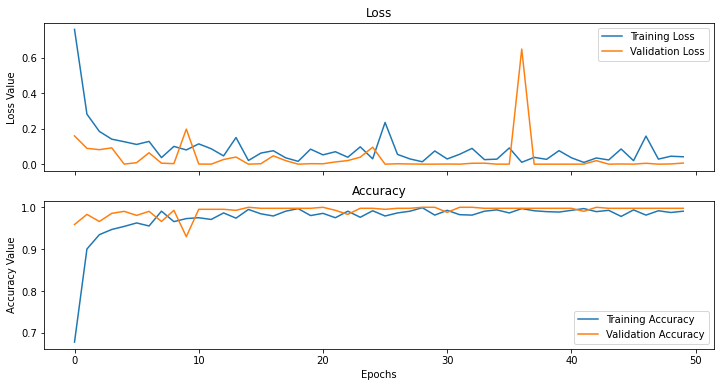

In [ ]:
import matplotlib.pyplot as plt
f, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6), sharex=True)
ax1.plot(history_2.history['loss'], label='Training Loss')
ax1.plot(history_2.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
#ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss Value')
ax1.legend()

#plt.subplot(2,1,2)
ax2.plot(history_2.history['accuracy'], label='Training Accuracy')
ax2.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy Value')
ax2.legend()

# Loading and Testing the Model

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/Data/Face Mask Detector/face_mask_vggface_vgg16.h5')


In [ ]:
import cv2
import numpy as np
im = cv2.imread('/content/drive/My Drive/Data/Face Mask Detector/temp_face2.png')
im = cv2.resize(im, (224,224))
im = im / 255
im = np.expand_dims(im,axis=0)
im.shape

(1, 224, 224, 3)

In [ ]:
pred = model.predict(im)
final_pred = np.argmax(pred, axis=1)
print(final_pred)

[1]
